$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 6: YOLO - Objects Detection
<a id=part6></a>

In this part we will use an object detection architecture called YOLO (You only look once) to detect objects in images. We'll use an already trained model weights (v5) found here: https://github.com/ultralytics/yolov5

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the YOLO model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")
model.to(device)
# Images
img1 = 'imgs/DolphinsInTheSky.jpg'  
img2 = 'imgs/cat-shiba-inu-2.jpg' 

Using cache found in /home/ilay.kamai/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-15 Python-3.8.12 torch-1.10.1 CPU



requirements: /home/ilay.kamai/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


## Inference with YOLO
<a id=part6_1></a>

You are provided with 2 images (img1 and img2).
**TODO**:
1. Detect objects using the YOLOv5 model for these 2 images.
2. Print the inference output with bounding boxes.
3. Calculate the number of pixels within a bounding box and the number in the background.
   
   **Hint**: Given you stored the model output in a varibale named 'results', you may find 'results.pandas().xyxy' helpful 
4. Look at the inference results and answer the question below.


imgs/DolphinsInTheSky.jpg
total number of pixels in all bounding boxes:  13173  0.26 of image pixels
total number of pixels in background:  37152  0.74 of image pixels


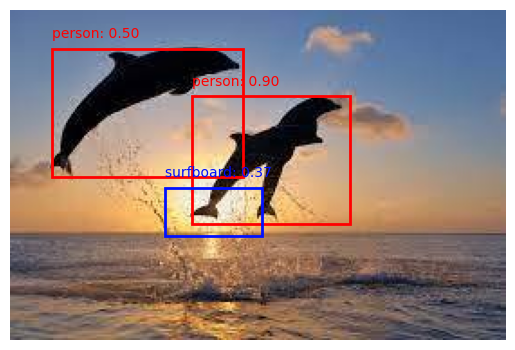

imgs/cat-shiba-inu-2.jpg
total number of pixels in all bounding boxes:  406433  0.72 of image pixels
total number of pixels in background:  156067  0.28 of image pixels


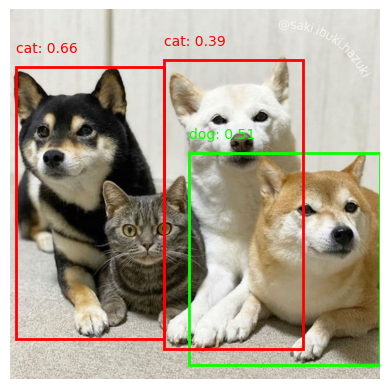

In [2]:
#Insert the inference code here.
import math
import cv2
import numpy as np
# from torch.nn.functional import pad
from matplotlib import pyplot as plt
%matplotlib inline
def plot_boxes(img, df):
    """
    Plot bounding boxes on image
    """
    colors = plt.cm.hsv(np.linspace(0, 1, len(df)+1).tolist())
    classes = df['class']
    plt.imshow(img)
    plt.axis('off')
    tot_box_size = 0
    ref_img = torch.zeros((img.shape[0], img.shape[1]))
    for i in range(len(df)):
        row = df.iloc[i]
        x1,y1,x2,y2 = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        conf = row['confidence']
        name = row['name']
        cls = row['class']
        ref_img[int(y1):int(y2), int(x1):int(x2)] =1
        tot_box_size += int((x2-x1)*(y2-y1))
#         x1, y1, x2, y2 = df[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
#         conf = confs[i]
#         cls = classes[i]
        color = colors[np.where(classes==cls)[0][0]]
        label = f"{name}: {conf:.2f}"
        y_offset = int(img.shape[0]*0.07)
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=2, edgecolor=color))
        plt.gca().text(x1, y1-y_offset, label,color=color, fontsize=10, ha='left', va='top')
    # plt.imshow(ref_img)
    # plt.show()
    tot_pixels = img.shape[0]*img.shape[1]
    box_pixels = len(torch.where(ref_img)[0])
    background_pixels = len(torch.where(ref_img==0)[0])
    print("total number of pixels in all bounding boxes: ", box_pixels, " {:.2f} of image pixels".format(box_pixels/tot_pixels))
    print("total number of pixels in background: ", background_pixels, " {:.2f} of image pixels".format(background_pixels/tot_pixels))
    
    plt.show()
img1_arr = cv2.imread(img1)[:,:,::-1] 
img2_arr = cv2.imread(img2)[:,:,::-1]
# plt.imshow(img2_arr)
# plt.show()
for im in [img1, img2]:
    print(im)
    with torch.no_grad():
        results = model(im)
        df = results.pandas().xyxy[0]
        # print(df)
        im_arr = cv2.imread(im)[:,:,::-1]
        plot_boxes(im_arr, df)


### Question 1

Analyze the inference results of the 2 images. 
1. How well did the model detect the objects in the pictures?
2. What can possibly be the reason for the model failures? suggest methods to resolve that issue.

In [3]:
from cs236781.answers import display_answer
import hw2.answers

In [4]:
display_answer(hw2.answers.part6_q1)



**Your answer:**


1. in generall, the model did not performed well on those pictures. in the first image there are three dolphins.
the model located on of the bounding box correctly, but the other two bounding boxes are not accurate. the labels is also
not accurate -  the model interperted the scene
as persons on a surfboard, and therefore labeled the dolphins as "person" or "surfboard". 
in the second image there are three dogs and one cat close to each other. here, the model 
located 2 bounding boxes over cat and dog together and labeled them as a cat.
this might related to the similarity between those kind of dogs and cats (model bias) and occlusion
<br> 
2. possible reasons for the poor performance are:
<br>
model bias -on both cases we can assumes the predictions were biased. in the first example - the model might trained on a dataset with many images of persons on surfboards and not many images of flighing dolphins , and therefore when it
see an object above the water it tend to interpert it as a person on a surfboard.
in the second example - this type of dogs are similiar to cats which can confuse the model (if it was not trained on many specific exmaples of dogs of this type)
occolusion - in the second image the cat is occluded by the dogs, and the model failed to locate it.
light conditions - in the first example, the dolphins are shaded by the sun, which makes them hard to identify.
another reason is the number of classes the model was trained on - for example, YOLOV5 has no dolphin class.
<br>
to resolve those issues we can: 
<br>
1. train the model on a dataset with more variability per class - many instances of the same class in different poses.
<br>
2. train the model with different size of bounding boxes to allow the model better seperate between close objects.
<br>
3. change the number of bounding boxes per grid cell to allow the model to locate more objects in the same grid cell. 
<br>
4. train the model on a dataset with more variability in light and geometrical conditions (data augmentations).
<br>
5. fine tune the model on a dataset with more classes.




## Creative Detection Failures

<a id=part6_2></a>

Object detection pitfalls could be, for example: **occlusion** - when the objects are partially occlude, and thus missing important features, **model bias** - when a model learn some bias about an object, it could recognize it as something else in a different setup, and many others like **Deformation**, **Illumination conditions**, **Cluttered** or **textured background and blurring** due to moving objects.

**TODO**: Take pictures and that demonstrates 3 of the above object detection pitfalls, run inference and analyze the results.

imgs/YOLO/ducks.png
total number of pixels in all bounding boxes:  1830  0.01 of image pixels
total number of pixels in background:  237486  0.99 of image pixels


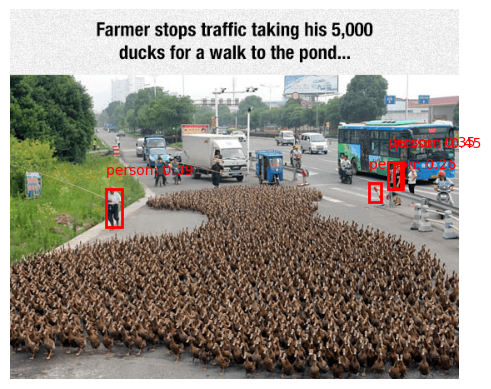

imgs/YOLO/cow_and_cat.jpeg
total number of pixels in all bounding boxes:  372931  0.54 of image pixels
total number of pixels in background:  316009  0.46 of image pixels


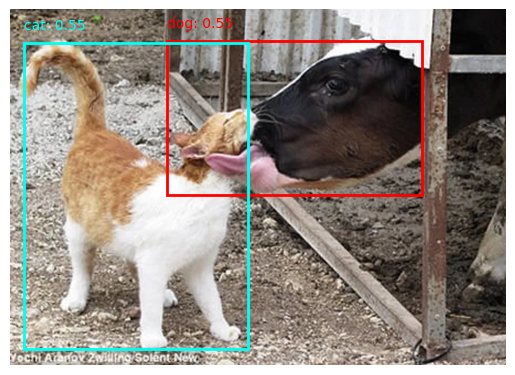

imgs/YOLO/cat-shiba-inu-2.jpg
total number of pixels in all bounding boxes:  406433  0.72 of image pixels
total number of pixels in background:  156067  0.28 of image pixels


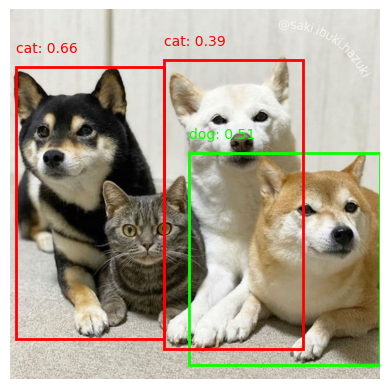

imgs/YOLO/shadow.jpeg
total number of pixels in all bounding boxes:  3347550  0.19 of image pixels
total number of pixels in background:  14568354  0.81 of image pixels


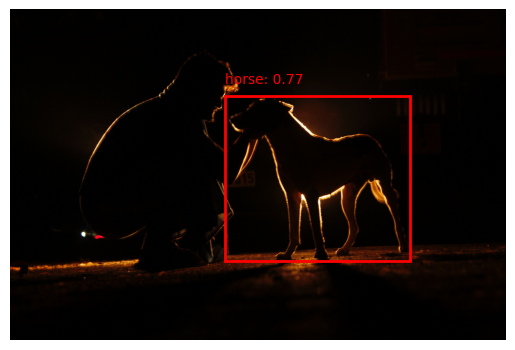

imgs/YOLO/bear2.jpg
total number of pixels in all bounding boxes:  523076  0.48 of image pixels
total number of pixels in background:  556924  0.52 of image pixels


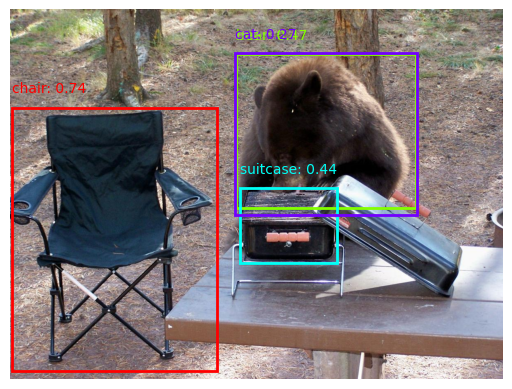

imgs/YOLO/DolphinsInTheSky.jpg
total number of pixels in all bounding boxes:  13173  0.26 of image pixels
total number of pixels in background:  37152  0.74 of image pixels


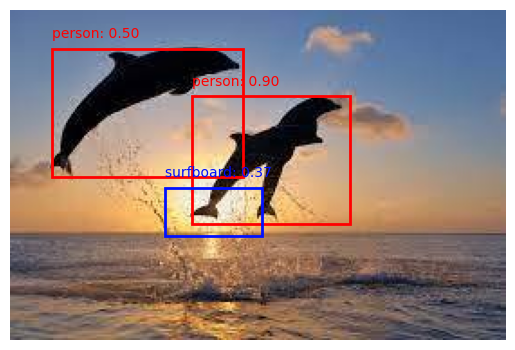

In [5]:
import os
imgs = [os.path.join("imgs/YOLO", f) for f in os.listdir("imgs/YOLO") if os.path.splitext(f)[1] in [".jpg", ".jpeg", ".png"]]
for im in imgs:
    print(im)
    with torch.no_grad():
        results = model(im)
        df = results.pandas().xyxy[0]
        im_arr = cv2.imread(im)[:,:,::-1]
        plot_boxes(im_arr, df)




### Question 3

Analyize the results of the inference. 
1. How well did the model detect the objects in the pictures? explain.


In [6]:
display_answer(hw2.answers.part6_q3)



**Your answer:**

the model shows different drawbacks in each one of the images. the first image shows many many little ducks on the road together with 
people and cars. the model catches the people baut fail to catch any of the ducks. this might be because they are very small and occluded objects (they masking each other and looks like one big object). it also don't recognize any of the cars at the background possibly because of hard light conditions. the second image shows a cow licking a cat. this time the model accurately puts bounding boxes and classify the cat but he misclassify the cow as a dog. this might be because of model bias - this scene is not normal and probably most of the images the model was trained on with some animal licking a cat was of dog or another cat. therefore, when the model see a cat licked by another animal, it mistakenly interpert it as a dog (or a cat) where's here its a cow. the third image is very interesting - we see a bear in a camping playing with a stove. the model gives two, almost identically, bounding boxes around the bear one labeld as a bear and the other one (with lower probabilty) as a cat. it is possible that two factors cause the confusion - 
<br>
1. the bear's head is down. this is a form of deformation that changes the shape of the bear and makes it harder to classify
<br>
2. this is another unusual scene (bear playing with a stove) and the classification of cat might relates to model bias (cat's are more common to play with humans stuff)
<br>
the last image is of man and dog in the dark. the model do not recognize the man and recognize the dog as a horse. this is because the dark ilumination blur most of the features the helps the model recognize the objects. 



## Bonus 
<a id=part6_3></a>

Try improving the model performance over poorly recognized images by changing them. 
Describe the manipulations you did to the pictures.

In [7]:
import torchvision.transforms as T
from PIL import Image
torch.manual_seed(0)
aug = T.AutoAugment()
imgs_to_aug = ['imgs/YOLO/ducks.png', 'imgs/YOLO/shadow.jpeg']
aug_imgs = [aug(Image.open(im)) for im in imgs_to_aug]
for name, im in zip(imgs_to_aug, aug_imgs):
    print(name)
    split = os.path.splitext(name)
    new_path = f"{split[0]}_aug{split[1]}"
    print(new_path)
    im.save(new_path)
    

imgs/YOLO/ducks.png
imgs/YOLO/ducks_aug.png
imgs/YOLO/shadow.jpeg
imgs/YOLO/shadow_aug.jpeg


imgs/YOLO/shadow_aug.jpeg
{'horse'}
total number of pixels in all bounding boxes:  7057327  0.39 of image pixels
total number of pixels in background:  10858577  0.61 of image pixels


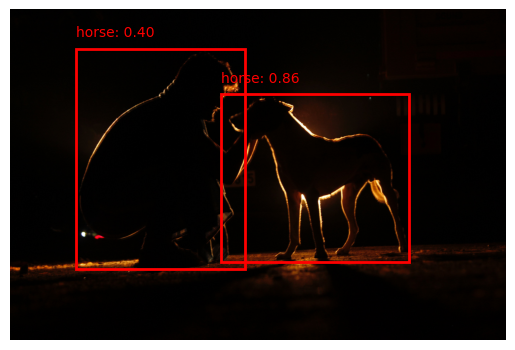

imgs/YOLO/cow_and_cat.jpeg
{'cat', 'dog'}
total number of pixels in all bounding boxes:  599211  0.87 of image pixels
total number of pixels in background:  89729  0.13 of image pixels


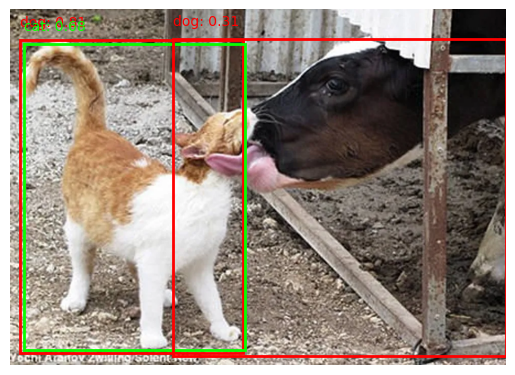

imgs/YOLO/cat-shiba-inu-2.jpg
{'cat', 'dog'}
total number of pixels in all bounding boxes:  406304  0.72 of image pixels
total number of pixels in background:  156196  0.28 of image pixels


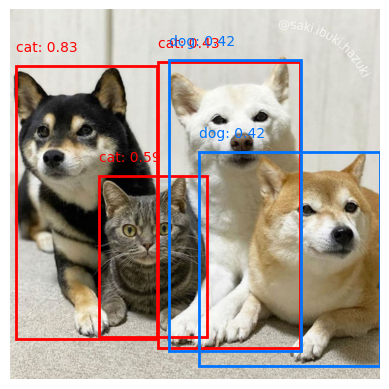

imgs/YOLO/bear2.jpg
{'bear', 'cell phone', 'cat', 'suitcase', 'dining table', 'chair'}
total number of pixels in all bounding boxes:  744540  0.69 of image pixels
total number of pixels in background:  335460  0.31 of image pixels


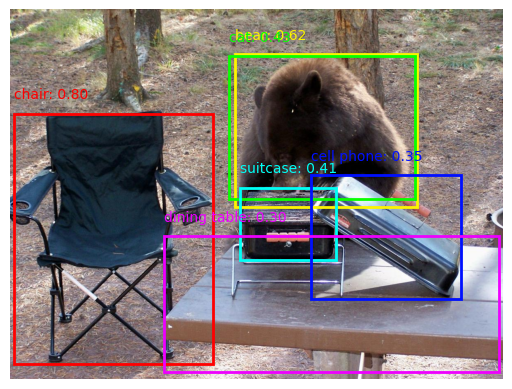

imgs/YOLO/DolphinsInTheSky.jpg
{'person', 'kite', 'bird'}
total number of pixels in all bounding boxes:  12683  0.25 of image pixels
total number of pixels in background:  37642  0.75 of image pixels


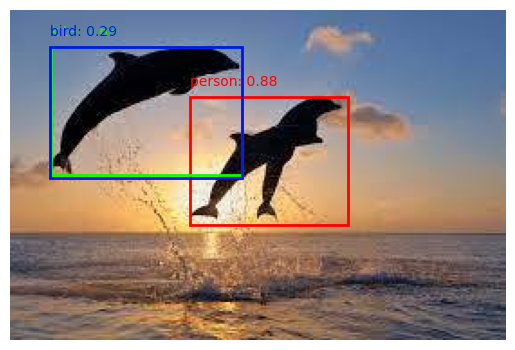

imgs/YOLO/ducks_aug.png
{'car', 'bus', 'motorcycle', 'person', 'truck'}
total number of pixels in all bounding boxes:  24994  0.10 of image pixels
total number of pixels in background:  214322  0.90 of image pixels


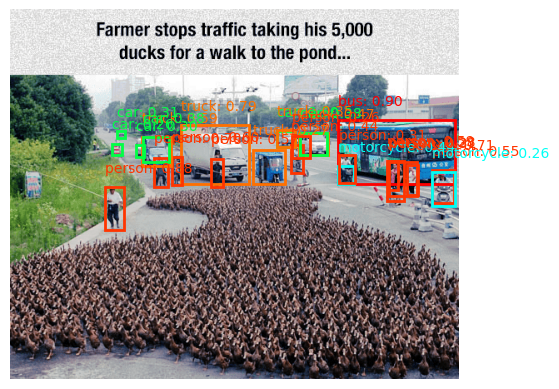

In [8]:

imgs = [os.path.join("imgs/YOLO", f) for f in os.listdir("imgs/YOLO") if os.path.splitext(f)[1] in [".jpg", ".jpeg", ".png"]]
for p in imgs_to_aug:
    imgs.remove(p)

class AugmentYOLO(torch.nn.Module):
    def __init__(self, yolo):
        super().__init__()
        self.yolo = yolo
    def forward(self, x, **kw):
        return self.yolo(x, **kw)
    def forward_augment(self, x):
        img_size = x.shape[-2:]  # height, width
        s = [1, 0.83, 0.67, 0.4]  # scales
        f = [None, 3, None, 2, None]  # flips (2-ud, 3-lr)
        y = []  # outputs
        for si, fi in zip(s, f):
            xi = scale_img(x.flip(fi) if fi else x, si, gs=int(self.stride.max()))
            yi = self.forward_once(xi)[0]  # forward
            # cv2.imwrite(f'img_{si}.jpg', 255 * xi[0].cpu().numpy().transpose((1, 2, 0))[:, :, ::-1])  # save
            yi = self._descale_pred(yi, fi, si, img_size)
            y.append(yi)
        return torch.cat(y, 1), None  # augmented inference, train
a_yolo = AugmentYOLO(model)

for im in imgs:
    print(im)
    with torch.no_grad():
        results = a_yolo(im, augment=True)
        df = results.pandas().xyxy[0]
        print(set(df['name']))
        im_arr = cv2.imread(im)[:,:,::-1]
        plot_boxes(im_arr, df)
    

In [9]:
display_answer(hw2.answers.part6_bonus)



**Your answer:**

we did two types of image augmentations - first we did general, automatic augmentation using torchvision autoaugment. this function uses a general augmentation policy defined by IMAGENET dataset. as autoaugment change the brightnes and not all images had brightness issues, we applied this only to images that we suspected to benefit from brightness adjustment. next, we applied geometrical augmentation on all images. this we done using the Test Time Augmentation (TTA) funcionality inside YOLOv5. to implement that we created a custom YOLO class which overrides the forward_augment method (that takes care of the TTA proccess). we can see that the the broghtness and geometry issues improved a lot by those augmentations - the cars that were not indentified are now identified very well. also the person in the dark now has correct bounding box (but with the wrong class). another example that was improved is the cat and the dogs - the model now locates the bounding box accurately and classiifed 2 of the animals correctly. issues related to model bias (for example cow leaking cat that was identified as a dog) was not affected as expected (this requires fune tuning of the model on new dataset)  to summarize - using simple augmenatations like autoaugment and TTA, we can improve predicitons significantly with almost zero effort.   

